# Train a Custom Object Detector using YOLOv5

In this notebook, you will learn how to train a YOLOv5 object detection model on a custom dataset. We will be training YOLOv5 *medium* model to detect **Drones**. The steps involved in training process are as follows.

1. Setting up dependencies
2. Dataset preparation
3. Visualization
4. Training
5. Inference

<img src="https://opencv.org/wp-content/uploads/2022/08/drone-detection-yolov5-custom-data.jpg" alt="YOLOv5 custom training">

## Import Dependencies

In [1]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np

np.random.seed(42)

## Download the Dataset

We will use the <a href="https://www.kaggle.com/datasets/sshikamaru/drone-yolo-detection" target="_blank">Drone-dataset</a> from Kaggle for training the custom YOLOv5 object detector. Note that the original dataset contains more than 4000 images and the annotations are not very good. Hence, we have trimmed down the dataset and improved annotation for faster and better training. Our dataset contains 526 images, split into training(70%), validation(10%) and test(20%) set.

In [2]:
if not os.path.exists('drone.zip'):
    !curl -L "https://www.dropbox.com/sh/he3b4skcbvp1625/AAD0FJiGmBkQfSPtvG4yTF81a?dl=1" > drone.zip; unzip drone.zip; rm drone.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   140  100   140    0     0    790      0 --:--:-- --:--:-- --:--:--   795
100    17  100    17    0     0     12      0  0:00:01  0:00:01 --:--:--    93
100 11.2M  100 11.2M    0     0   545k      0  0:00:21  0:00:21 --:--:--  135k
Archive:  drone.zip
mapname:  conversion of  failed
   creating: test/
   creating: train/
   creating: valid/
 extracting: data.yaml               
   creating: inference/
   creating: test/images/
   creating: test/labels/
   creating: train/images/
   creating: train/labels/
   creating: valid/images/
   creating: valid/labels/
 extracting: inference/drone-test3.jpg  
 extracting: inference/drone-test2.jpg  
 extracting: inference/drone-test1.jpg  
 extracting: test/images/49_JPEG.rf.8c2f0608750c9deb68c9e8332869beeb.jpg  
 extracting: test/images/79_JPEG.rf.91ae3ed6100ed7e4125f80583fecb259.jpg  

The dataset is structured in the following manner:

```
├── data.yaml
├── test
│   ├── images
│   └── labels
├── train
│   ├── images
│   └── labels
└── valid
    ├── images
    └── labels

```
The `labels` directory contains `label.txt` files that consists of annotation data. YOLOv5 Pytorch normalised format is as follows.

```
class_label   center_x   center_y   width   height

0 0.5132211538461539 0.6069711538461539 0.9591346153846154 0.4795673076923077
```

### The Dataset YAML File

The dataset YAML (`data.yaml`) file containing the path to the training and validation images and labels is already provided. This file will also contain the class names from the dataset. The Drone dataset contains 1 class: **'drone'**.

The following block shows the contents of the `data.yaml` file.

```yaml
train: ../train/images
test: ../test/images
val: ../valid/images

nc: 1
names: ['drone']
```

### Visualize a Few Ground Truth Images

Before moving forward, let's check out few of the ground truth images. The current annotations in the text files are in normalized `[x_center, y_center, width, height]` format. Let's write a function that will convert it back to `[x_min, y_min, x_max, y_max]` format.

In [3]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [4]:
class_names = ['drone']

The following function `plot_box()` renders bounding box around the objects according to the annotated data.

In [5]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize the bounding box coordinates.
    h, w = image.shape[:2]

    for box_num, box in enumerate(bboxes):
        # Obtain top_left and bottom_right corners.
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        # Width and height of the bounding box.
        width = xmax - xmin
        height = ymax - ymin

        class_name = class_names[int(labels[box_num])]

        # Render bounding box around the object.
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color=(0,0,255), thickness=max(2, int(w/275)))

        # Render labels.
        font_scale = min(1, max(4,int(w/500)))
        font_thickness = min(1, max(10,int(w/50)))
        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))

        # Text width and height.
        tw, th = cv2.getTextSize(class_name, 0, fontScale=font_scale, thickness=font_thickness)[0]

        p2 = p1[0] + tw, p1[1] + -th - 10

        cv2.rectangle(image, p1, p2, color=(255,0,0), thickness=-1)
        cv2.putText(image, class_name, (xmin+1, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), font_thickness, cv2.LINE_AA)

    return image

### Function to visualize random images with the bounding boxes


In [6]:
def visualize(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()

    num_images = len(all_training_images)

    plt.figure(figsize=(20, 17))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

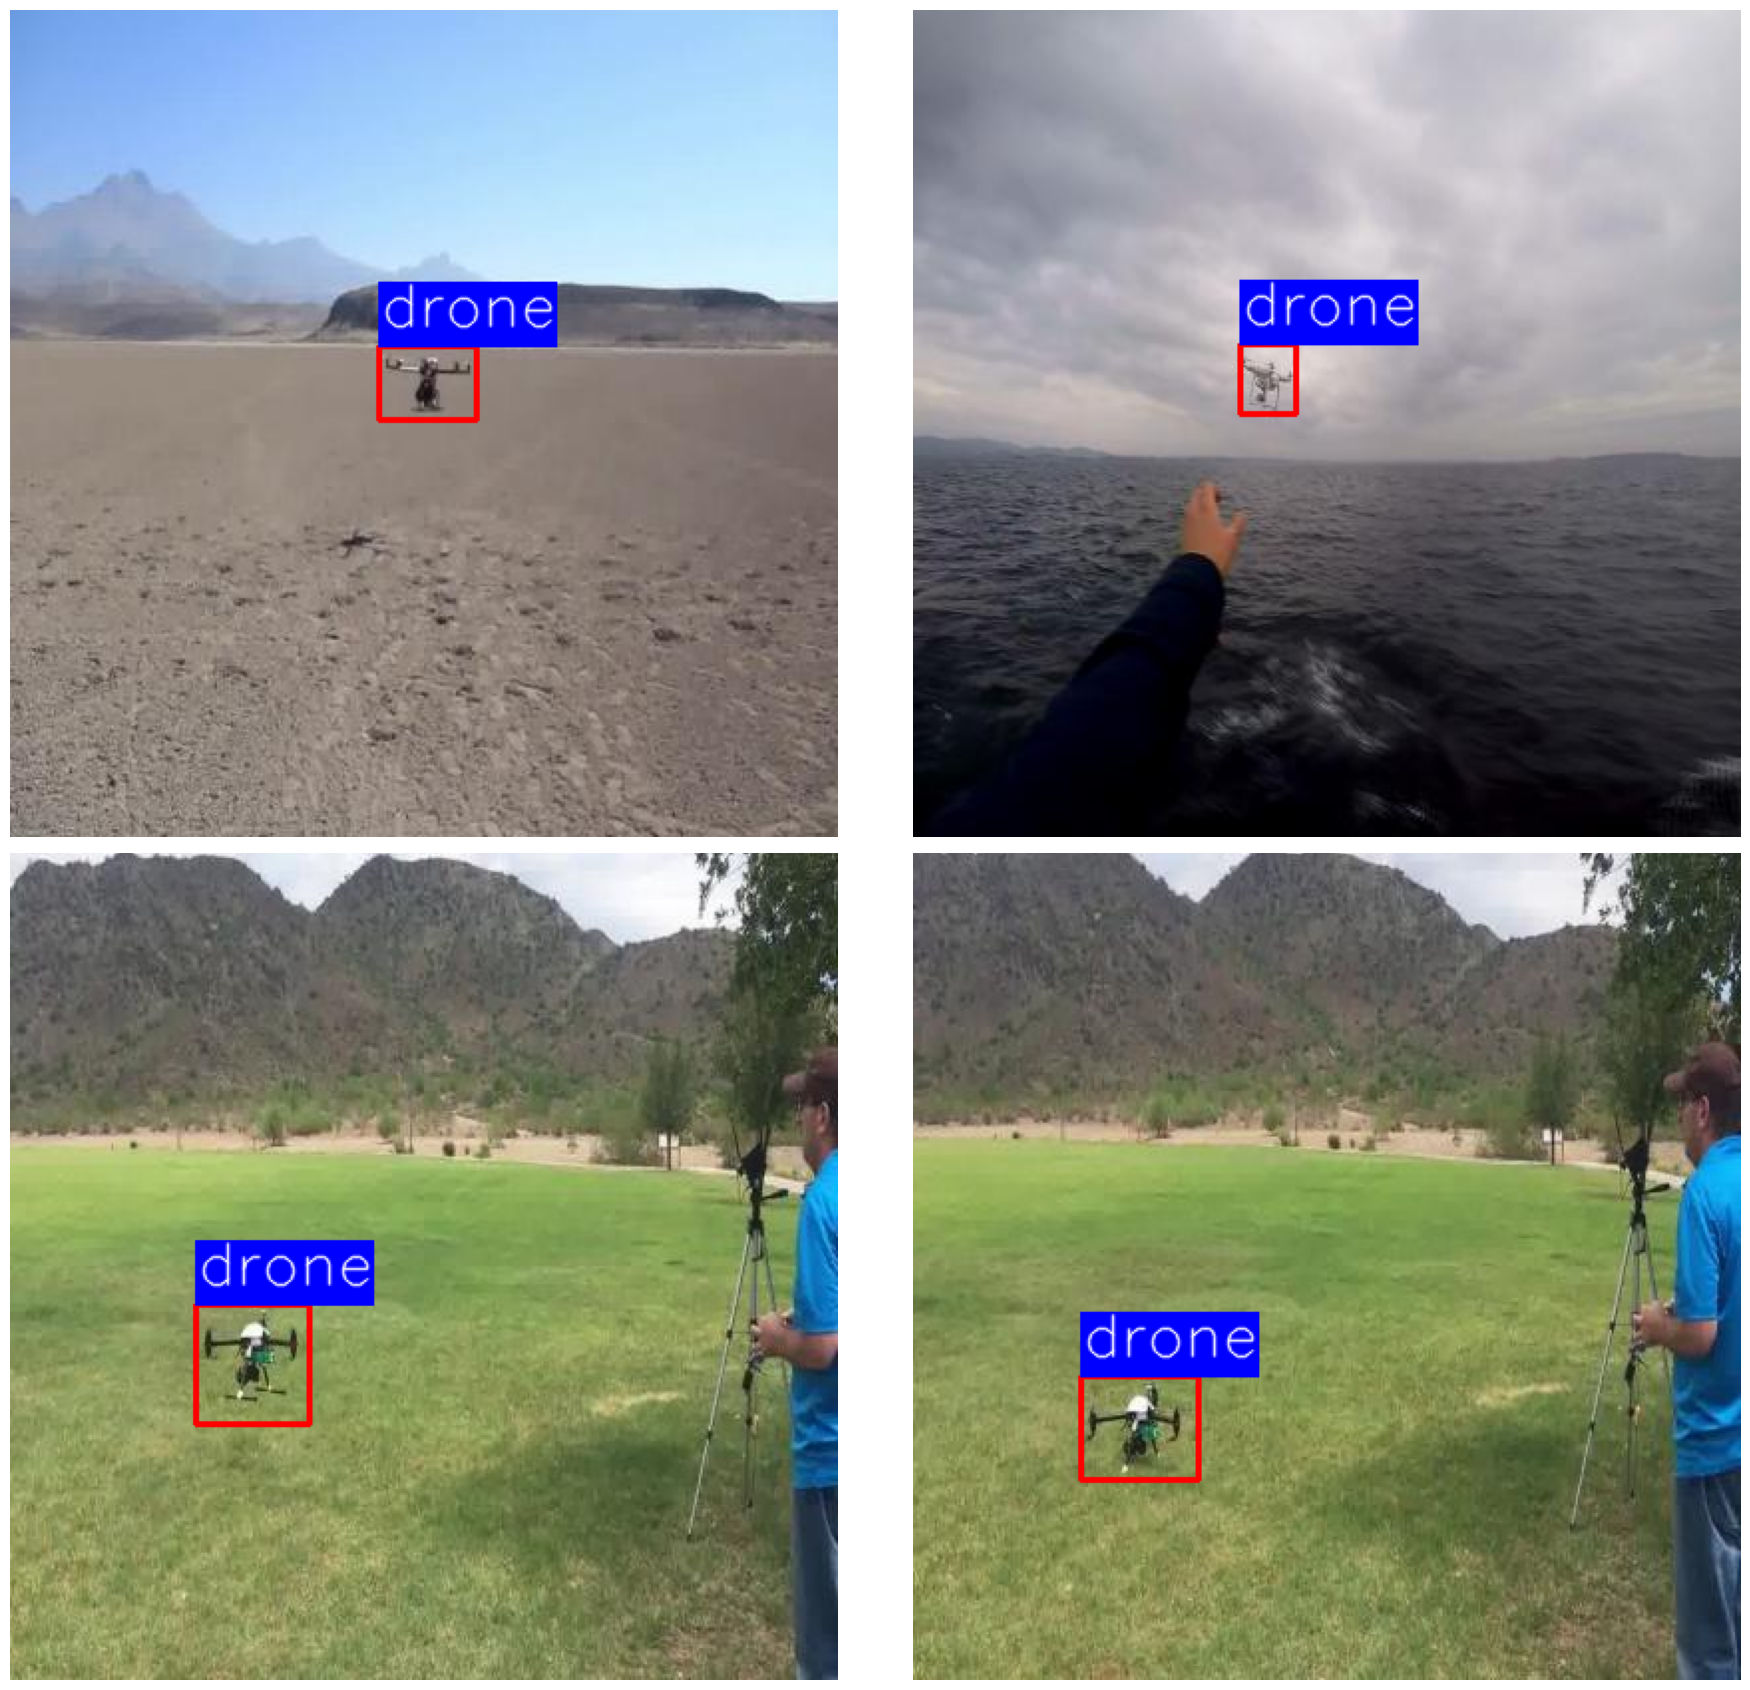

In [7]:
# Visualize a few training images.
visualize(
    image_paths='train/images/*',
    label_paths='train/labels/*',
    num_samples=4,
)

## Clone YOLOV5 Repository

In [8]:
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 17521, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 17521 (delta 9), reused 0 (delta 0), pack-reused 17497 (from 4)
Receiving objects: 100% (17521/17521), 16.62 MiB | 30.08 MiB/s, done.
Resolving deltas: 100% (12005/12005), done.


In [9]:
%cd yolov5/
!pwd

/content/yolov5
/content/yolov5


In [10]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


## Training using YOLOV5

The next step is to train the neural network model. Here, we are going to train YOLOv5 medium model.

* As we have already mentioned above, `data.yaml` file contains information about the data path and labels. It has to be specifically mentioned through `--data` flag that we are using custom dataset.

* The flag `--weights` specify the model that we are going to use for Transfer learning. If the model is not present in the root directory, YOLOv5 will download it automatically.

* The flag `--img` is used to specify the size of the training or validation image. The images are resized to the specified size before training. You can also use `--imgsz` or `--img-size`. All of them serve the same purpose. The size should be a multiple of 32.

* You can play with total number of training epochs and observe how mAP improves.

* The flag `--batch-size` says how many images to be processed at once.



In [11]:
!python train.py --data ../data.yaml --weights yolov5m.pt --img 640 --epochs {25} --batch-size 32

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-08-09 15:07:49.672158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754752069.953662    1221 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754752070.029571    1221 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS wh

## Testing

In [12]:
!python val.py --task 'test' --weights runs/train/exp/weights/best.pt --data ../data.yaml

val: data=../data.yaml, weights=['runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-423-g567c6646 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 212 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
test: Scanning /content/test/labels... 89 images, 0 backgrounds, 0 corrupt: 100% 89/89 [00:00<00:00, 745.79it/s]
test: New cache created: /content/test/labels.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 3/3 [00:04<00:00,  1.48s/it]
                   all         89        107      0.997      0.981      0.994      0.601
Speed: 0.4ms pre-process, 21.1ms inference, 4.1ms NMS per image at shape (32, 3, 640, 6

## Inference
In this section, we will carry out inference on unseen images and videos from the internet. Note that the `inferece_results` folder will change with every run. Make sure to change the path if you are running the block more than once.

detect: weights=['runs/train/exp/weights/best.pt'], source=../inference, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=inference_results, name=., exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-423-g567c6646 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 212 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
image 1/3 /content/inference/drone-test1.jpg: 384x640 2 drones, 68.9ms
image 2/3 /content/inference/drone-test2.jpg: 448x640 (no detections), 46.4ms
image 3/3 /content/inference/drone-test3.jpg: 480x640 3 drones, 46.0ms
Speed: 0.6ms pre-process, 53.8ms inference, 64.1ms NMS per image at shape (1, 3, 640, 640)
Resul

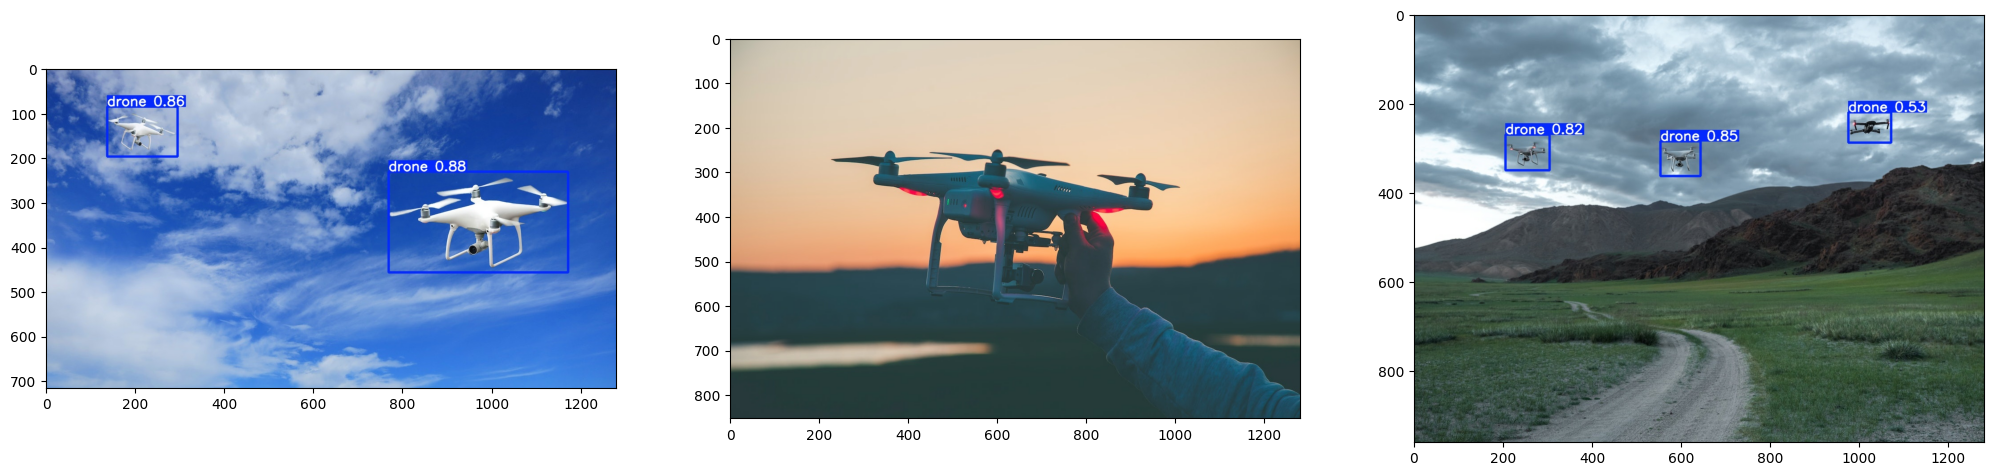

In [13]:
# Run inference.
!python detect.py --source ../inference --weights runs/train/exp/weights/best.pt --project inference_results --name .
plt.figure(figsize=(25,15))
for i in range(3):
  img = cv2.imread('./inference_results/drone-test{}.jpg'.format(i+1))
  plt.subplot(1, 3, i+1);
  plt.imshow(img[...,::-1]);

## Download Model


In [14]:
from google.colab import files
files.download('runs/train/exp/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>